In [69]:
import pandas as pd
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score, log_loss, confusion_matrix

In [70]:
# Carregando o conjunto de dados Iris
iris = load_iris()
X = iris.data
y = iris.target

# Definindo o modelo Random Forest
rf_model = RandomForestClassifier()

In [71]:
# Definindo o modelo Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X, y)

RandomForestClassifier()

In [95]:
def cria_lista_roc_auc(y_pred, avarage, class_labels):
    roc_auc_list = []

    # Calculando ROC AUC para cada classe
    for i in range(len(class_labels)):
        # Crie um array binário indicando a classe atual vs. todas as outras classes
        y_binary = [1 if label == i else 0 for label in y]

        # Calcule o ROC AUC para a classe atual
        roc_auc = roc_auc_score(y_binary, y_pred, average=avarage)
        
        roc_auc_list.append(roc_auc)

    # Exiba a lista de ROC AUC para cada classe
    return roc_auc_list

def calculate_log_loss_for_classes(model, X, y, class_labels):
    class_labels = list(set(y))
    log_loss_list = []

    for i, class_label in enumerate(class_labels):
        y_binary = [1 if label == class_label else 0 for label in y]
        y_prob = model.predict_proba(X)
        y_prob_class = y_prob[:, i]
        logloss = log_loss(y_binary, y_prob_class)
        log_loss_list.append(logloss)

    return log_loss_list

In [106]:
def evaluate_model_with_cross_validation(model, X, y, class_labels, cv=3):
    y_pred = cross_val_predict(model, X, y, cv=cv)
    
    accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    precision = cross_val_score(model, X, y, cv=cv, scoring='precision_weighted')
    recall = cross_val_score(model, X, y, cv=cv, scoring='recall_weighted')
    f1 = cross_val_score(model, X, y, cv=cv, scoring='f1_weighted')

    confusion = confusion_matrix(y, y_pred)

    result_dict = {
        'Class': class_labels,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Confusion Matrix': [c.tolist() for c in confusion]
        
    }

    return result_dict

In [108]:
# Realizando validação cruzada cv é a quantidade de dobras que serão realizadas para a avaliação do modelo
class_labels = ["Iris Setosa", "Iris Versicolor", "Iris Virginica"]
df_score = evaluate_model_with_cross_validation(rf_model, X, y, class_labels, cv=3)
df_score

{'Class': ['Iris Setosa', 'Iris Versicolor', 'Iris Virginica'],
 'Accuracy': array([0.98, 0.94, 0.98]),
 'Precision': array([0.98111111, 0.94088889, 0.98111111]),
 'Recall': array([0.98, 0.94, 0.98]),
 'F1 Score': array([0.97996313, 0.9398894 , 0.97998268]),
 'Confusion Matrix': [[50, 0, 0], [0, 47, 3], [0, 2, 48]]}

#### With multiple iterations

In [136]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

def refine_params_with_iterations(rf_model, X, y, param_grid, num_iterations=5, scoring='f1_weighted'):
    best_score = None
    best_params = None

    for _ in range(num_iterations):
        # Perform the initial or refined grid search
        grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring=scoring)
        grid_search.fit(X, y)

        # Get the best parameters from the current search
        current_best_params = grid_search.best_params_
        current_best_score = grid_search.best_score_

        # If the current score is better than the previous best score, update the best parameters
        if best_score is None or current_best_score > best_score:
            best_score = current_best_score
            best_params = current_best_params

        # Refine the parameter grid for the next iteration
        param_grid = refine_param_grid(current_best_params, rf_model)

    return best_params, best_score

def refine_param_grid(best_params, rf_model):
    max_depth = best_params.get('max_depth', None)

    if max_depth is None:
        max_depth = max(estimator.tree_.max_depth for estimator in rf_model.estimators_)

    refined_param_grid = {
        'n_estimators': [abs(int(best_params['n_estimators'] / 2)), abs(best_params['n_estimators']), abs(best_params['n_estimators'] * 2)],
        'max_depth': [abs(int(max_depth / 2)), max_depth, max_depth * 2]
    }
    return refined_param_grid


param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}

best_params, best_score = refine_params_with_iterations(rf_model, X, y, param_grid, num_iterations=5, scoring='f1_weighted')

print("Best Parameters after Refinement:", best_params)
print("Best Score after Refinement:", best_score)

Best Parameters after Refinement: {'max_depth': None, 'n_estimators': 200}
Best Score after Refinement: 0.9666117395149653


#### With only one itteration of refine_param_grid

In [139]:
# Initial parameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}

# Perform the initial grid search
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='f1_weighted')
grid_search.fit(X, y)

# Get the best parameters from the initial search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Refine the parameter grid
refined_param_grid = refine_param_grid(best_params, rf_model)

# Perform a refined grid search
refined_grid_search = GridSearchCV(estimator=rf_model, param_grid=refined_param_grid, cv=3, scoring='f1_weighted')
refined_grid_search.fit(X, y)

# Display the results of the refined search
print("Best Parameters after Refinement:", refined_grid_search.best_params_)
print("Best Score after Refinement:", refined_grid_search.best_score_)

Best Parameters after Refinement: {'max_depth': 9, 'n_estimators': 50}
Best Score after Refinement: 0.9666117395149653


In [147]:
import numpy as np
def gini_index(y_true, y_pred):
    n = len(y_true)
    sorted_indices = np.argsort(y_pred)
    sorted_y_true = y_true[sorted_indices]
    cumulative_sum = np.cumsum(sorted_y_true)
    total_positives = np.sum(sorted_y_true)
    
    gini_sum = np.sum(cumulative_sum) / total_positives - (n + 1) / 2
    gini_index = gini_sum / n

    return gini_index

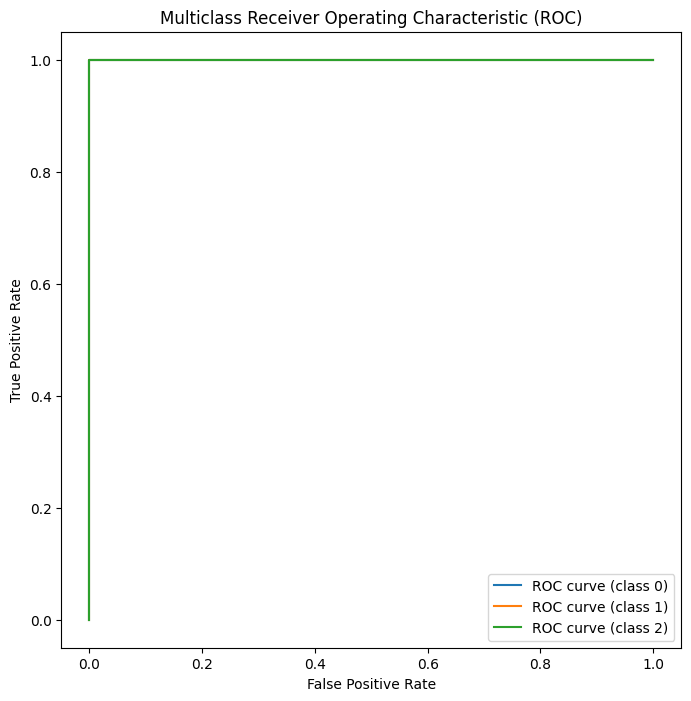

In [144]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_multiclass_roc_curve(model, X, y):
    n_classes = len(model.classes_)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    y_pred = model.predict_proba(X)
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y == i, y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(8, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve (class {})'.format(i))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

plot_multiclass_roc_curve(rf_model, X, y)

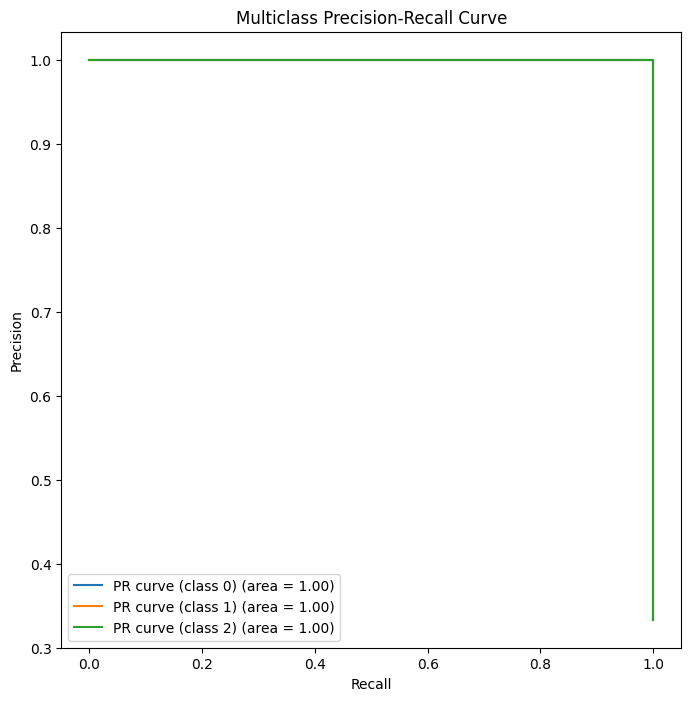

In [146]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_multiclass_precision_recall_curve(model, X, y):
    n_classes = len(model.classes_)
    precision = dict()
    recall = dict()
    pr_auc = dict()

    y_pred = model.predict_proba(X)

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y == i, y_pred[:, i])
        pr_auc[i] = average_precision_score(y == i, y_pred[:, i])

    plt.figure(figsize=(8, 8))
    for i in range(n_classes):
        plt.plot(recall[i], precision[i], label='PR curve (class {}) (area = {:.2f})'.format(i, pr_auc[i]))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Multiclass Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

plot_multiclass_precision_recall_curve(rf_model, X, y)

In [149]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, average_precision_score, cohen_kappa_score, matthews_corrcoef, jaccard_score, log_loss, balanced_accuracy_score

def evaluate_model(model, X, y):
    # Make predictions
    y_pred = model.predict(X)
    
    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')  # Use 'weighted' for multiclass
    recall = recall_score(y, y_pred, average='weighted')  # Use 'weighted' for multiclass
    f1 = f1_score(y, y_pred, average='weighted')  # Use 'weighted' for multiclass
    cm = confusion_matrix(y, y_pred)
    
    roc_auc = roc_auc_score(y, model.predict_proba(X), multi_class='ovr')  # Use 'ovr' for multiclass
    pr_auc = average_precision_score(y, model.predict_proba(X), average='weighted')  # Use 'weighted' for multiclass
    
    kappa = cohen_kappa_score(y, y_pred)
    mcc = matthews_corrcoef(y, y_pred)
    jaccard = jaccard_score(y, y_pred, average='weighted')  # Use 'weighted' for multiclass
    logloss = log_loss(y, model.predict_proba(X))
    balanced_accuracy = balanced_accuracy_score(y, y_pred)
    
    # Create a DataFrame
    df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'AUC-PR', 'Kappa', 'MCC', 'Jaccard Index', 'Log Loss', 'Balanced Accuracy'],
        'Value': [accuracy, precision, recall, f1, roc_auc, pr_auc, kappa, mcc, jaccard, logloss, balanced_accuracy]
    })
    
    return df

evaluate_model(rf_model, X, y)

,Metric,Value
0,Accuracy,1.000000
1,Precision,1.000000
2,Recall,1.000000
3,F1-Score,1.000000
4,AUC-ROC,1.000000
5,AUC-PR,1.000000
6,Kappa,1.000000
7,MCC,1.000000
8,Jaccard Index,1.000000
9,Log Loss,0.022708
